In [19]:
import polars as pl
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Utils

Please refer to the function's doc string to understand its functioning.

In [20]:
def lagged_table(df, n_lag):
    
    """
    Create a lagged feature table by generating lagged versions of each column in the dataframe, 
    excluding the 'client_id', 'period', and 'category' columns. The function returns a new dataframe 
    that includes these lagged features, where each lagged column is shifted by 1 to n_lag periods.

    Parameters:
    -----------
    df: DataFrame
        The input dataframe containing the original features. It must contain 'client_id' and 'period' columns.
    n_lag: int
        The number of lagged periods to create for each feature.

    Returns:
    --------
    DataFrame
        A new dataframe with the original 'client_id' and 'period' columns, and additional columns for each 
        lagged feature. Rows with missing values generated by the lagging process are dropped.
    """

    lag_columns = []
    
    cols = [col for col in df.columns if col != 'client_id' and col != 'period' and col != 'category']
    
    for i in range(1, n_lag+1):
        
        for col in cols: 

            lag_columns.append(df[col].shift(i).alias(f'{col}_t-{i}'))
            
    df = df.with_columns(['period', 'client_id'] + lag_columns)
    df = df.filter(pl.col('period') > n_lag)

    return df.drop_nulls()

# Filter by removing people that always paid back

In [21]:
# train = pl.read_csv('Data/training.csv')
# averge_repaying = train.group_by('client_id').agg(pl.col('repays_debt').mean())
# client_not_repaying = averge_repaying.filter(pl.col('repays_debt') > 0).select(pl.col('client_id'))
# client_repaying = averge_repaying.filter(pl.col('repays_debt') == 0).select(pl.col('client_id'))
# client_repaying = client_repaying.slice(offset = 0, length = len(client_not_repaying))
# subset_client = pl.concat([client_repaying,client_not_repaying], how = 'vertical')
# red_df_train = train.filter(pl.col('client_id').is_in(subset_client['client_id']))

Import the subsampled data, previously obtained and saved in the notebook **reduced_df**.

In [22]:
reduced_df = pl.read_csv('Data/average_repaying.csv')

Filter by retaining in the training set only the `client_id` that are present in **reduced_df**.

In [23]:
df_train = pl.read_csv('Data/training.csv')
df_train = df_train.filter(pl.col('client_id').is_in(reduced_df['client_id']))

The `category` variable has a numerical encoding, and we believe it is better to OneHot encode this, by creating three dummy variables and then removing one of them, to avoid perfect collinearity.

In [24]:
encoded_category = df_train['category'].to_dummies(drop_first = True)
df_train = pl.concat([df_train, encoded_category], how = 'horizontal')

Apply the function defined above.

In [25]:
lag_df = lagged_table(df_train, 2)

Let's see the class imbalance.

In [26]:
lag_df['repays_debt'].value_counts()

repays_debt,count
i64,u32
1,5946
0,14430


## LightGBM - model creation and fitting

Generate the feature matrix, `X`, and the target variable, `y`.

In [27]:
X = lag_df.select([col for col in lag_df.columns if col != 'repays_debt'])
y = lag_df.select(['repays_debt']).to_numpy()

In [28]:
X.shape

(20376, 131)

Apply StandardScaler to ensure higher performance.

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Train test split.

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify = y)

Define and fit the model, in this case it's LightGBM with a slight modification with respect to its baseline parameters' values.

In [31]:
model = lgb.LGBMClassifier(n_estimators = 1000, max_depth = 20, 
                           num_leaves = 400, random_state = 42,
                           is_unbalance=True, n_jobs = -1)

model.fit(X_train, y_train)

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 5351, number of negative: 12987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6232
[LightGBM] [Info] Number of data points in the train set: 18338, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291798 -> initscore=-0.886665
[LightGBM] [Info] Start training from score -0.886665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(is_unbalance=True, max_depth=20, n_estimators=1000, n_jobs=-1,
               num_leaves=400, random_state=42)

# Validation

Predict the probability for each observation.

In [32]:
y_pred_val_prob = model.predict_proba(X_val)[:, 1]

We set a threshold _t_ to define how the predictions must be converted to binary values:

$$
\hat{y} = 
\begin{cases} 
0 & \text{if } \text{pred\_proba} < t \\
1 & \text{otherwise}
\end{cases}


$$

In [33]:
threshold = 0.5
y_pred_val = (y_pred_val_prob > threshold).astype(int)

In [34]:
# np.unique(y_pred_val, return_counts = True)

Inspect the model performance

In [35]:
print(f'F1 Score: {f1_score(y_val, y_pred_val)}')
print(f'Classification Report:\n{classification_report(y_val, y_pred_val)}')

F1 Score: 0.9379194630872483
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1443
           1       0.94      0.94      0.94       595

    accuracy                           0.96      2038
   macro avg       0.96      0.96      0.96      2038
weighted avg       0.96      0.96      0.96      2038



Confusion matrix to visualize in depth False Positives, True Positives, etc...

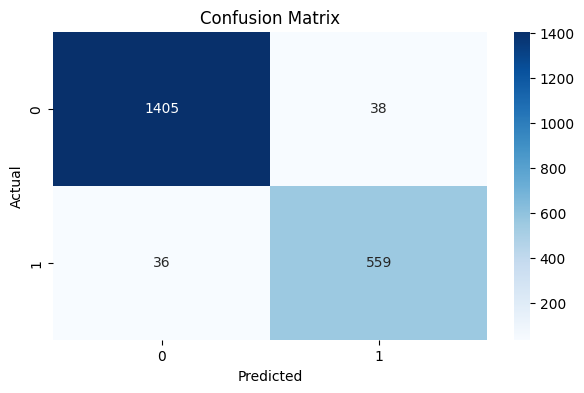

In [36]:
cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(7,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Test set predictions

Load the test dataframe, and apply the same preprocessing done for the training set.

In [37]:
df_test = pl.read_csv('Data/test.csv')

encoded_category = df_test['category'].to_dummies()
print(f"test shape: {df_test.shape}")

df_test = pl.concat([df_test, encoded_category], how = 'horizontal')
df_test = df_test.drop(['category_2'])
print(f"test shape: {df_test.shape}")

test shape: (7890, 44)
test shape: (7890, 46)


In [38]:
test_df = lagged_table(df_test, 2)
test_df = test_df.filter(pl.col('repays_debt') == '??')
print(f"test shape: {test_df.shape}")

test shape: (718, 132)


In [39]:
X_test = test_df.select([col for col in test_df.columns if col != 'repays_debt'])

In [40]:
X_test.shape, X.shape

((718, 131), (20376, 131))

Apply the Scaler fitted previously.

In [41]:
X_scaled_test = scaler.transform(X_test)

In [42]:
y_pred_test = model.predict_proba(X_scaled_test)[:, 1]

Convert the predicted probabilities to 0/1.

In [43]:
threshold = 0.5
y_pred_test = (y_pred_test > threshold).astype(int)

In [44]:
np.unique(y_pred_test, return_counts = True)

(array([0, 1]), array([356, 362], dtype=int64))

Save the predictions

In [45]:
pd.DataFrame({'Label' : y_pred_test}).to_csv('Predictions/LightGBM-Checkup2.csv', index = False)